<a href="https://colab.research.google.com/github/knowhrishi/DLTA/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Dropout, CuDNNLSTM, GRU, Masking, Embedding, Dense, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Bidirectional

In [ ]:
ds_train = pd.read_csv('/content/drive/My Drive/train.csv')
ds_asset = pd.read_csv('/content/drive/My Drive/asset_details.csv')
ds_example = pd.read_csv('/content/drive/My Drive/example_test.csv')
ds_suplement_train = pd.read_csv('/content/drive/My Drive/supplemental_train.csv')


FileNotFoundError: ignored

In [ ]:
ds_train[ds_train['Target']==np.nan]
ds_train.isna().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

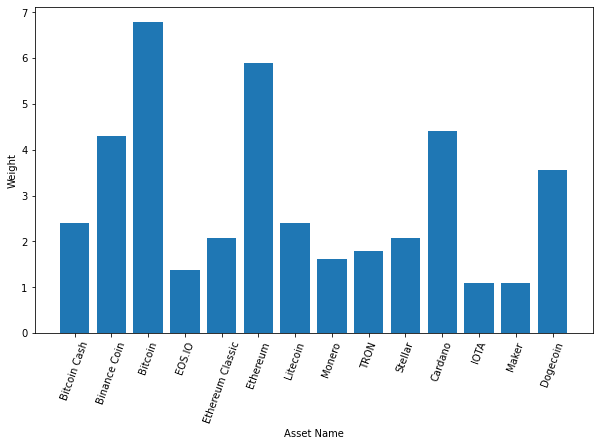

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create bar plot
ax.bar(ds_asset['Asset_Name'], 
       ds_asset['Weight'])
plt.xlabel('Asset Name')
plt.ylabel('Weight')
plt.xticks(rotation=70)
plt.show()

In [ ]:
ds_train_copy = ds_train
ds_train_copy['date'] = pd.to_datetime(ds_train_copy['timestamp'], unit='s')
ds_train_copy.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,date
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218,2018-01-01 00:01:00
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399,2018-01-01 00:01:00
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643,2018-01-01 00:01:00
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922,2018-01-01 00:01:00
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264,2018-01-01 00:01:00


In [ ]:
bnc = ds_train_copy[ds_train_copy['Asset_ID']==0].set_index('timestamp')
btc = ds_train_copy[ds_train_copy['Asset_ID']==1].set_index('timestamp')
btcsh = ds_train_copy[ds_train_copy['Asset_ID']==2].set_index('timestamp')
car = ds_train_copy[ds_train_copy['Asset_ID']==3].set_index('timestamp')
dog = ds_train_copy[ds_train_copy['Asset_ID']==4].set_index('timestamp')
eos = ds_train_copy[ds_train_copy['Asset_ID']==5].set_index('timestamp')
eth = ds_train_copy[ds_train_copy['Asset_ID']==6].set_index('timestamp')
eth_csc = ds_train_copy[ds_train_copy['Asset_ID']==7].set_index('timestamp')
iot = ds_train_copy[ds_train_copy['Asset_ID']==8].set_index('timestamp')
ltc = ds_train_copy[ds_train_copy['Asset_ID']==9].set_index('timestamp')
mak = ds_train_copy[ds_train_copy['Asset_ID']==10].set_index('timestamp')
mon = ds_train_copy[ds_train_copy['Asset_ID']==11].set_index('timestamp')
ste = ds_train_copy[ds_train_copy['Asset_ID']==12].set_index('timestamp')
tro = ds_train_copy[ds_train_copy['Asset_ID']==13].set_index('timestamp')

In [ ]:
beg_btcsh = btcsh.index[0].astype('datetime64[s]')
end_btcsh = btcsh.index[-1].astype('datetime64[s]')
beg_bnc = bnc.index[0].astype('datetime64[s]')
end_bnc = bnc.index[-1].astype('datetime64[s]')
beg_btc = btc.index[0].astype('datetime64[s]')
end_btc = btc.index[-1].astype('datetime64[s]')
beg_eos = eos.index[0].astype('datetime64[s]')
end_eos = eos.index[-1].astype('datetime64[s]')
beg_eth_csc = eth_csc.index[0].astype('datetime64[s]')
end_eth_csc = eth_csc.index[-1].astype('datetime64[s]')
beg_ltc = ltc.index[0].astype('datetime64[s]')
end_ltc = ltc.index[-1].astype('datetime64[s]')
beg_mon = mon.index[0].astype('datetime64[s]')
end_mon = mon.index[-1].astype('datetime64[s]')
beg_tro = tro.index[0].astype('datetime64[s]')
end_tro = tro.index[-1].astype('datetime64[s]')
beg_eth = eth.index[0].astype('datetime64[s]')
end_eth = eth.index[-1].astype('datetime64[s]')
beg_ste = ste.index[0].astype('datetime64[s]')
end_ste = ste.index[-1].astype('datetime64[s]')
beg_car = car.index[0].astype('datetime64[s]')
end_car = car.index[-1].astype('datetime64[s]')
beg_iot = iot.index[0].astype('datetime64[s]')
end_iot = iot.index[-1].astype('datetime64[s]')
beg_mak = mak.index[0].astype('datetime64[s]')
end_mak = mak.index[-1].astype('datetime64[s]')
beg_dog = dog.index[0].astype('datetime64[s]')
end_dog = dog.index[-1].astype('datetime64[s]')
print('Bitcoin Cash     :', beg_btcsh, 'to', end_btcsh)
print('Binance Coin     :', beg_bnc, 'to', end_bnc)
print('Bitcoin          :', beg_btc, 'to', end_btc)
print('EOS IO           :', beg_eos, 'to', end_eos)
print('Etherium Classic :', beg_eth_csc, 'to', end_eth_csc)
print('Ethereum         :', beg_eth, 'to', end_eth)
print('Lite Coin        :', beg_ltc, 'to', end_ltc)
print('Monero           :', beg_mon, 'to', end_mon)
print('TRON             :', beg_tro, 'to', end_tro)
print('Stellar          :', beg_ste, 'to', end_ste)
print('Cardano          :', beg_car, 'to', end_car)
print('IOTA             :', beg_iot, 'to', end_iot)
print('Maker            :', beg_mak, 'to', end_mak)
print('Dogecoin         :', beg_dog, 'to', end_dog)

Bitcoin Cash     : 2018-01-01T00:01:00 to 2021-09-21T00:00:00
Binance Coin     : 2018-01-01T00:01:00 to 2021-09-21T00:00:00
Bitcoin          : 2018-01-01T00:01:00 to 2021-09-21T00:00:00
EOS IO           : 2018-01-01T00:01:00 to 2021-09-21T00:00:00
Etherium Classic : 2018-01-01T00:01:00 to 2021-09-21T00:00:00
Ethereum         : 2018-01-01T00:01:00 to 2021-09-21T00:00:00
Lite Coin        : 2018-01-01T00:01:00 to 2021-09-21T00:00:00
Monero           : 2018-01-01T00:01:00 to 2021-09-21T00:00:00
TRON             : 2018-02-06T21:37:00 to 2021-09-21T00:00:00
Stellar          : 2018-02-16T23:53:00 to 2021-09-21T00:00:00
Cardano          : 2018-04-17T09:11:00 to 2021-09-21T00:00:00
IOTA             : 2018-05-09T08:07:00 to 2021-09-21T00:00:00
Maker            : 2018-05-10T15:21:00 to 2021-09-21T00:00:00
Dogecoin         : 2019-04-12T14:34:00 to 2021-09-21T00:00:00


In [ ]:
(eth.index[1:]-eth.index[:-1]).value_counts().head()

60     1956043
120        100
180         23
300          5
540          4
Name: timestamp, dtype: int64

In [ ]:
eth     = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='pad')
btc     = btc.reindex(range(btc.index[0],btc.index[-1]+60,60),method='pad')
btcsh   = btcsh.reindex(range(btcsh.index[0],btcsh.index[-1]+60,60),method='pad')
bnc     = bnc.reindex(range(bnc.index[0],bnc.index[-1]+60,60),method='pad')
eos     = eos.reindex(range(eos.index[0],eos.index[-1]+60,60),method='pad')
eth_csc = eth_csc.reindex(range(eth_csc.index[0],eth_csc.index[-1]+60,60),method='pad')
ltc     = ltc.reindex(range(ltc.index[0],ltc.index[-1]+60,60),method='pad')
mon     = mon.reindex(range(mon.index[0],mon.index[-1]+60,60),method='pad')
tro     = tro.reindex(range(tro.index[0],tro.index[-1]+60,60),method='pad')
ste     = ste.reindex(range(ste.index[0],ste.index[-1]+60,60),method='pad')
car     = car.reindex(range(car.index[0],car.index[-1]+60,60),method='pad')
iot     = iot.reindex(range(iot.index[0],iot.index[-1]+60,60),method='pad')
mak     = mak.reindex(range(mak.index[0],mak.index[-1]+60,60),method='pad')
dog     = dog.reindex(range(dog.index[0],dog.index[-1]+60,60),method='pad')

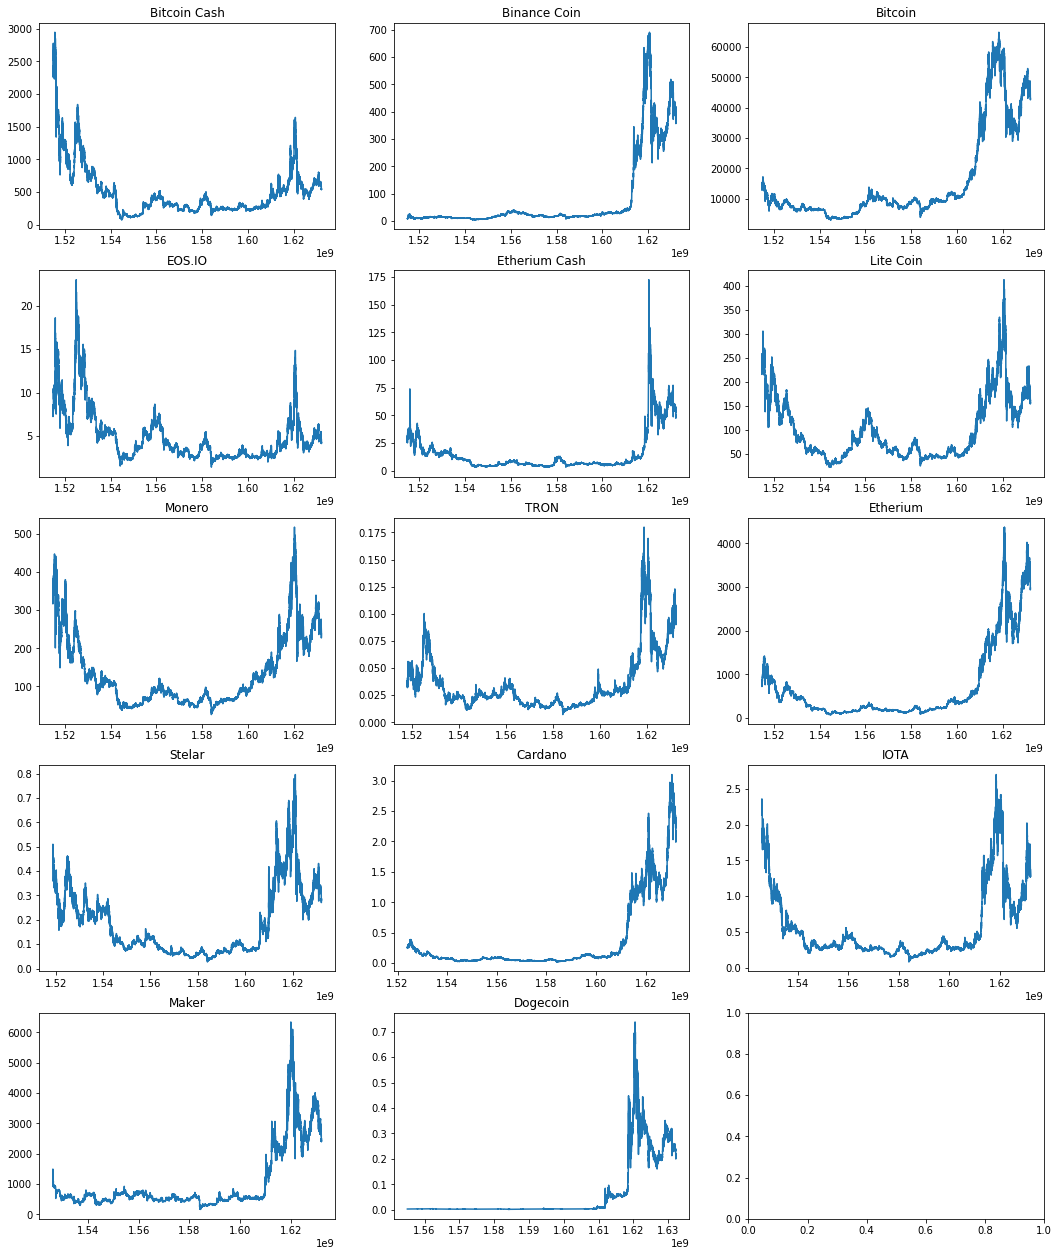

In [ ]:
# Define plot space
fig, ax = plt.subplots(5, 3, figsize=(18, 22))

# Bitcoin Cash
ax[0, 0].plot(btcsh['Close'], label='BTCSH')
ax[0, 0].set_title('Bitcoin Cash')
ax[0, 1].plot(bnc['Close'], label='BNC')
ax[0, 1].set_title('Binance Coin')
ax[0, 2].plot(btc['Close'], label='BTC')
ax[0, 2].set_title('Bitcoin')
ax[1, 0].plot(eos['Close'], label='EOS')
ax[1, 0].set_title('EOS.IO')
ax[1, 1].plot(eth_csc['Close'], label='ETH_CSC')
ax[1, 1].set_title('Etherium Cash')
ax[1, 2].plot(ltc['Close'], label='LTC')
ax[1, 2].set_title('Lite Coin')
ax[2, 0].plot(mon['Close'], label='MON')
ax[2, 0].set_title('Monero')
ax[2, 1].plot(tro['Close'], label='TRO')
ax[2, 1].set_title('TRON')
ax[2, 2].plot(eth['Close'], label='ETH')
ax[2, 2].set_title('Etherium')
ax[3, 0].plot(ste['Close'], label='STE')
ax[3, 0].set_title('Stelar')
ax[3, 1].plot(car['Close'], label='CAR')
ax[3, 1].set_title('Cardano')
ax[3, 2].plot(iot['Close'], label='IOT')
ax[3, 2].set_title('IOTA')
ax[4, 0].plot(mak['Close'], label='MAK')
ax[4, 0].set_title('Maker')
ax[4, 1].plot(dog['Close'], label='DOG')
ax[4, 1].set_title('Dogecoin')
plt.show()

In [ ]:
# define function to compute log returns
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

all_assets_2021 = pd.DataFrame([])
for asset_id, asset_name in zip(ds_asset.Asset_ID, ds_asset.Asset_Name):
    asset = ds_train[ds_train["Asset_ID"]==asset_id].set_index("timestamp")
    asset = asset.loc[totimestamp('01/01/2021'):totimestamp('01/05/2021')]
    asset = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')
    lret = log_return(asset.Close.fillna(0))[1:]
    all_assets_2021 = all_assets_2021.join(lret, rsuffix=asset_name, how="outer")

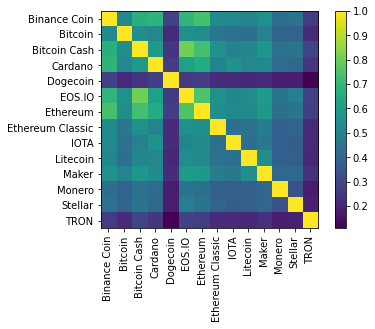

In [ ]:
plt.imshow(all_assets_2021.corr());
plt.yticks(ds_asset.Asset_ID.values, ds_asset.Asset_Name.values);
plt.xticks(ds_asset.Asset_ID.values, ds_asset.Asset_Name.values, rotation='vertical');
plt.colorbar();

In [ ]:
upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low
X_bnc = pd.concat([log_return(bnc.VWAP,periods=15), log_return(bnc.VWAP,periods=1).abs(), upper_shadow(bnc), lower_shadow(bnc)], axis=1)
y_bnc = bnc.Target
X_btc = pd.concat([log_return(btc.VWAP,periods=15), log_return(btc.VWAP,periods=1).abs(), upper_shadow(btc), lower_shadow(btc)], axis=1)
y_btc = btc.Target
X_btcsh = pd.concat([log_return(btcsh.VWAP,periods=15), log_return(btcsh.VWAP,periods=1).abs(), upper_shadow(btcsh), lower_shadow(btcsh)], axis=1)
y_btcsh = btcsh.Target
X_car = pd.concat([log_return(car.VWAP,periods=15), log_return(car.VWAP,periods=1).abs(), upper_shadow(car), lower_shadow(car)], axis=1)
y_car = car.Target
X_dog = pd.concat([log_return(dog.VWAP,periods=15), log_return(dog.VWAP,periods=1).abs(), upper_shadow(dog), lower_shadow(dog)], axis=1)
y_dog = dog.Target
X_eos = pd.concat([log_return(eos.VWAP,periods=15), log_return(eos.VWAP,periods=1).abs(), upper_shadow(eos), lower_shadow(eos)], axis=1)
y_eos = eos.Target
X_eth = pd.concat([log_return(eth.VWAP,periods=15), log_return(eth.VWAP,periods=1).abs(), upper_shadow(eth), lower_shadow(eth)], axis=1)
y_eth = eth.Target
X_eth_csc = pd.concat([log_return(eth_csc.VWAP,periods=15), log_return(eth_csc.VWAP,periods=1).abs(), upper_shadow(eth_csc), lower_shadow(eth_csc)], axis=1)
y_eth_csc = eth_csc.Target
X_iot = pd.concat([log_return(iot.VWAP,periods=15), log_return(iot.VWAP,periods=1).abs(), upper_shadow(iot), lower_shadow(iot)], axis=1)
y_iot = iot.Target
X_ltc = pd.concat([log_return(ltc.VWAP,periods=15), log_return(ltc.VWAP,periods=1).abs(), upper_shadow(ltc), lower_shadow(ltc)], axis=1)
y_ltc = ltc.Target
X_mak = pd.concat([log_return(mak.VWAP,periods=15), log_return(mak.VWAP,periods=1).abs(), upper_shadow(mak), lower_shadow(mak)], axis=1)
y_mak = mak.Target
X_mon = pd.concat([log_return(mon.VWAP,periods=15), log_return(mon.VWAP,periods=1).abs(), upper_shadow(mon), lower_shadow(mon)], axis=1)
y_mon = mon.Target
X_ste = pd.concat([log_return(ste.VWAP,periods=15), log_return(ste.VWAP,periods=1).abs(), upper_shadow(ste), lower_shadow(ste)], axis=1)
y_ste = ste.Target
X_tro = pd.concat([log_return(tro.VWAP,periods=15), log_return(tro.VWAP,periods=1).abs(), upper_shadow(tro), lower_shadow(tro)], axis=1)
y_tro = tro.Target

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
train_window = [totimestamp("01/05/2021"), totimestamp("30/06/2021")]
test_window = [totimestamp("01/07/2021"), totimestamp("30/08/2021")]

# divide data into train and test, compute X and y
# we aim to build simple regression models using a window_size of 1
X_bnc_train = X_bnc.loc[train_window[0]:train_window[1]].ffill().to_numpy()
X_bnc_train = X_bnc.loc[train_window[0]:train_window[1]].bfill().to_numpy()
y_bnc_train = y_bnc.loc[train_window[0]:train_window[1]].ffill().to_numpy()
y_bnc_train = y_bnc.loc[train_window[0]:train_window[1]].bfill().to_numpy()
X_bnc_test = X_bnc.loc[test_window[0]:test_window[1]].ffill().to_numpy() 
X_bnc_test = X_bnc.loc[test_window[0]:test_window[1]].bfill().to_numpy() 
y_bnc_test = y_bnc.loc[test_window[0]:test_window[1]].ffill().to_numpy() 
y_bnc_test = y_bnc.loc[test_window[0]:test_window[1]].bfill().to_numpy() 

X_btc_train = X_btc.loc[train_window[0]:train_window[1]].ffill().to_numpy()
X_btc_train = X_btc.loc[train_window[0]:train_window[1]].bfill().to_numpy()
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].ffill().to_numpy()  
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].bfill().to_numpy() 
X_btc_test = X_btc.loc[test_window[0]:test_window[1]].ffill().to_numpy() 
X_btc_test = X_btc.loc[test_window[0]:test_window[1]].bfill().to_numpy()
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].ffill().to_numpy() 
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].bfill().to_numpy() 

X_btcsh_train = X_btcsh.loc[train_window[0]:train_window[1]].ffill().to_numpy()
X_btcsh_train = X_btcsh.loc[train_window[0]:train_window[1]].bfill().to_numpy()
y_btcsh_train = y_btcsh.loc[train_window[0]:train_window[1]].ffill().to_numpy()
y_btcsh_train = y_btcsh.loc[train_window[0]:train_window[1]].bfill().to_numpy()  
X_btcsh_test = X_btcsh.loc[test_window[0]:test_window[1]].ffill().to_numpy()
X_btcsh_test = X_btcsh.loc[test_window[0]:test_window[1]].bfill().to_numpy()
y_btcsh_test = y_btcsh.loc[test_window[0]:test_window[1]].ffill().to_numpy()
y_btcsh_test = y_btcsh.loc[test_window[0]:test_window[1]].bfill().to_numpy() 

X_car_train = X_car.loc[train_window[0]:train_window[1]].ffill().to_numpy()
X_car_train = X_car.loc[train_window[0]:train_window[1]].bfill().to_numpy()
y_car_train = y_car.loc[train_window[0]:train_window[1]].ffill().to_numpy()
y_car_train = y_car.loc[train_window[0]:train_window[1]].bfill().to_numpy()  
X_car_test = X_car.loc[test_window[0]:test_window[1]].ffill().to_numpy()   
X_car_test = X_car.loc[test_window[0]:test_window[1]].bfill().to_numpy() 
y_car_test = y_car.loc[test_window[0]:test_window[1]].ffill().to_numpy() 
y_car_test = y_car.loc[test_window[0]:test_window[1]].bfill().to_numpy() 

X_dog_train = X_dog.loc[train_window[0]:train_window[1]].ffill().to_numpy()
X_dog_train = X_dog.loc[train_window[0]:train_window[1]].bfill().to_numpy()
y_dog_train = y_dog.loc[train_window[0]:train_window[1]].ffill().to_numpy()
y_dog_train = y_dog.loc[train_window[0]:train_window[1]].bfill().to_numpy()  
X_dog_test = X_dog.loc[test_window[0]:test_window[1]].ffill().to_numpy()   
X_dog_test = X_dog.loc[test_window[0]:test_window[1]].bfill().to_numpy() 
y_dog_test = y_dog.loc[test_window[0]:test_window[1]].ffill().to_numpy() 
y_dog_test = y_dog.loc[test_window[0]:test_window[1]].bfill().to_numpy() 

X_eos_train = X_eos.loc[train_window[0]:train_window[1]].ffill().to_numpy() 
X_eos_train = X_eos.loc[train_window[0]:train_window[1]].bfill().to_numpy()
y_eos_train = y_eos.loc[train_window[0]:train_window[1]].ffill().to_numpy()
y_eos_train = y_eos.loc[train_window[0]:train_window[1]].bfill().to_numpy()  
X_eos_test = X_eos.loc[test_window[0]:test_window[1]].ffill().to_numpy()   
X_eos_test = X_eos.loc[test_window[0]:test_window[1]].bfill().to_numpy() 
y_eos_test = y_eos.loc[test_window[0]:test_window[1]].ffill().to_numpy() 
y_eos_test = y_eos.loc[test_window[0]:test_window[1]].bfill().to_numpy() 

X_eth_train = X_eth.loc[train_window[0]:train_window[1]].ffill().to_numpy() 
X_eth_train = X_eth.loc[train_window[0]:train_window[1]].bfill().to_numpy() 
y_eth_train = y_eth.loc[train_window[0]:train_window[1]].ffill().to_numpy() 
y_eth_train = y_eth.loc[train_window[0]:train_window[1]].bfill().to_numpy()  
X_eth_test = X_eth.loc[test_window[0]:test_window[1]].ffill().to_numpy()  
X_eth_test = X_eth.loc[test_window[0]:test_window[1]].bfill().to_numpy() 
y_eth_test = y_eth.loc[test_window[0]:test_window[1]].ffill().to_numpy() 
y_eth_test = y_eth.loc[test_window[0]:test_window[1]].bfill().to_numpy() 

X_eth_csc_train = X_eth_csc.loc[train_window[0]:train_window[1]].ffill().to_numpy()
X_eth_csc_train = X_eth_csc.loc[train_window[0]:train_window[1]].bfill().to_numpy()  
y_eth_csc_train = y_eth_csc.loc[train_window[0]:train_window[1]].ffill().to_numpy()  
y_eth_csc_train = y_eth_csc.loc[train_window[0]:train_window[1]].bfill().to_numpy()  
X_eth_csc_test = X_eth_csc.loc[test_window[0]:test_window[1]].ffill().to_numpy()   
X_eth_csc_test = X_eth_csc.loc[test_window[0]:test_window[1]].bfill().to_numpy() 
y_eth_csc_test = y_eth_csc.loc[test_window[0]:test_window[1]].ffill().to_numpy() 
y_eth_csc_test = y_eth_csc.loc[test_window[0]:test_window[1]].bfill().to_numpy() 

X_iot_train = X_iot.loc[train_window[0]:train_window[1]].ffill().to_numpy()
X_iot_train = X_iot.loc[train_window[0]:train_window[1]].bfill().to_numpy()  
y_iot_train = y_iot.loc[train_window[0]:train_window[1]].ffill().to_numpy()  
y_iot_train = y_iot.loc[train_window[0]:train_window[1]].bfill().to_numpy()  
X_iot_test = X_iot.loc[test_window[0]:test_window[1]].ffill().to_numpy()   
X_iot_test = X_iot.loc[test_window[0]:test_window[1]].bfill().to_numpy() 
y_iot_test = y_iot.loc[test_window[0]:test_window[1]].ffill().to_numpy() 
y_iot_test = y_iot.loc[test_window[0]:test_window[1]].bfill().to_numpy() 

X_ltc_train = X_ltc.loc[train_window[0]:train_window[1]].ffill().to_numpy()  
X_ltc_train = X_ltc.loc[train_window[0]:train_window[1]].bfill().to_numpy()
y_ltc_train = y_ltc.loc[train_window[0]:train_window[1]].ffill().to_numpy()
y_ltc_train = y_ltc.loc[train_window[0]:train_window[1]].bfill().to_numpy()  
X_ltc_test = X_ltc.loc[test_window[0]:test_window[1]].ffill().to_numpy()   
X_ltc_test = X_ltc.loc[test_window[0]:test_window[1]].bfill().to_numpy() 
y_ltc_test = y_ltc.loc[test_window[0]:test_window[1]].ffill().to_numpy() 
y_ltc_test = y_ltc.loc[test_window[0]:test_window[1]].bfill().to_numpy() 

X_mak_train = X_mak.loc[train_window[0]:train_window[1]].ffill().to_numpy()
X_mak_train = X_mak.loc[train_window[0]:train_window[1]].bfill().to_numpy()   
y_mak_train = y_mak.loc[train_window[0]:train_window[1]].ffill().to_numpy()   
y_mak_train = y_mak.loc[train_window[0]:train_window[1]].bfill().to_numpy()  
X_mak_test = X_mak.loc[test_window[0]:test_window[1]].ffill().to_numpy()  
X_mak_test = X_mak.loc[test_window[0]:test_window[1]].bfill().to_numpy() 
y_mak_test = y_mak.loc[test_window[0]:test_window[1]].ffill().to_numpy()
y_mak_test = y_mak.loc[test_window[0]:test_window[1]].bfill().to_numpy()

X_mak_train = X_mak.loc[train_window[0]:train_window[1]].ffill().to_numpy()
X_mak_train = X_mak.loc[train_window[0]:train_window[1]].bfill().to_numpy()  
y_mak_train = y_mak.loc[train_window[0]:train_window[1]].ffill().to_numpy()  
y_mak_train = y_mak.loc[train_window[0]:train_window[1]].bfill().to_numpy()  
X_mak_test = X_mak.loc[test_window[0]:test_window[1]].ffill().to_numpy()   
X_mak_test = X_mak.loc[test_window[0]:test_window[1]].bfill().to_numpy() 
y_mak_test = y_mak.loc[test_window[0]:test_window[1]].ffill().to_numpy()
y_mak_test = y_mak.loc[test_window[0]:test_window[1]].bfill().to_numpy()

X_mon_train = X_mon.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()
X_mon_train = X_mon.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  
y_mon_train = y_mon.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  
y_mon_train = y_mon.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  
X_mon_test = X_mon.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()   
X_mon_test = X_mon.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_mon_test = y_mon.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()

X_ste_train = X_ste.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  
y_ste_train = y_ste.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  
X_ste_test = X_ste.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_ste_test = y_ste.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()

X_tro_train = X_tro.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  
y_tro_train = y_tro.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  
X_tro_test = X_tro.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_tro_test = y_tro.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()

In [ ]:
from sklearn.preprocessing import StandardScaler
# simple preprocessing of the data 
scaler = StandardScaler()

X_bnc_train_scaled = scaler.fit_transform(X_bnc_train)
X_bnc_test_scaled = scaler.transform(X_bnc_test)

X_btc_train_scaled = scaler.fit_transform(X_btc_train)
X_btc_test_scaled = scaler.transform(X_btc_test)

X_btcsh_train_scaled = scaler.fit_transform(X_btcsh_train)
X_btcsh_test_scaled = scaler.transform(X_btcsh_test)

X_car_train_scaled = scaler.fit_transform(X_car_train)
X_car_test_scaled = scaler.transform(X_car_test)

X_dog_train_scaled = scaler.fit_transform(X_dog_train)
X_dog_test_scaled = scaler.transform(X_dog_test)

X_eos_train_scaled = scaler.fit_transform(X_eos_train)
X_eos_test_scaled = scaler.transform(X_eos_test)

X_eth_train_scaled = scaler.fit_transform(X_eth_train)
X_eth_test_scaled = scaler.transform(X_eth_test)

X_eth_csc_train_scaled = scaler.fit_transform(X_eth_csc_train)
X_eth_csc_test_scaled = scaler.transform(X_eth_csc_test)

X_iot_train_scaled = scaler.fit_transform(X_iot_train)
X_iot_test_scaled = scaler.transform(X_iot_test)

X_ltc_train_scaled = scaler.fit_transform(X_ltc_train)
X_ltc_test_scaled = scaler.transform(X_ltc_test)

X_mak_train_scaled = scaler.fit_transform(X_mak_train)
X_mak_test_scaled = scaler.transform(X_mak_test)

X_mon_train_scaled = scaler.fit_transform(X_mon_train)
X_mon_test_scaled = scaler.transform(X_mon_test)

X_ste_train_scaled = scaler.fit_transform(X_ste_train)
X_ste_test_scaled = scaler.transform(X_ste_test)

X_tro_train_scaled = scaler.fit_transform(X_tro_train)
X_tro_test_scaled = scaler.transform(X_tro_test)

In [ ]:
list_asset = [['bnc',[X_bnc_train_scaled,y_bnc_train], [X_bnc_test_scaled, y_bnc_test]],
              ['btc',[X_btc_train_scaled,y_btc_train], [X_btc_test_scaled, y_btc_test]],
              ['btcsh',[X_btcsh_train_scaled,y_btcsh_train], [X_btcsh_test_scaled, y_btcsh_test]],
              ['car',[X_car_train_scaled,y_car_train], [X_car_test_scaled, y_car_test]],
              ['dog',[X_dog_train_scaled,y_dog_train], [X_dog_test_scaled, y_dog_test]],
              ['eos',[X_eos_train_scaled,y_eos_train], [X_eos_test_scaled, y_eos_test]],
              ['eth',[X_eth_train_scaled,y_eth_train], [X_eth_test_scaled, y_eth_test]],
              ['eth_csc',[X_eth_csc_train_scaled,y_eth_csc_train], [X_eth_csc_test_scaled, y_eth_csc_test]],
              ['iot',[X_iot_train_scaled,y_iot_train], [X_iot_test_scaled, y_iot_test]],
              ['ltc',[X_ltc_train_scaled,y_ltc_train], [X_ltc_test_scaled, y_ltc_test]],
              ['mak',[X_mak_train_scaled,y_mak_train], [X_mak_test_scaled, y_mak_test]],
              ['mon',[X_mon_train_scaled,y_mon_train], [X_mon_test_scaled, y_mon_test]],
              ['ste',[X_ste_train_scaled,y_ste_train], [X_ste_test_scaled, y_ste_test]],
              ['tro',[X_tro_train_scaled,y_tro_train], [X_tro_test_scaled, y_tro_test]]]

In [ ]:
def reshape(X_samples, y_samples):
    # Reshape the Input as a 3D (number of samples, Time Steps, Features)
    # X_data=np.array(X_samples)
    print(X_samples.shape)
    X_data = X_samples
    y_data = y_samples
    X_data=X_data.reshape(X_data.shape[0],1, X_data.shape[1])
    # We do not reshape y as a 3D data  as it is supposed to be a single column only
    # y_data=np.array(y_samples)
    y_data=y_data.reshape(y_data.shape[0], 1)
    
    return X_data, y_data

In [ ]:
def get_model_ltsm(x_train):
    TimeSteps=x_train.shape[0]
    TotalFeatures=x_train.shape[2]
    model = Sequential()
    model.add(LSTM(units = 15, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
    model.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
    model.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
    model.add(Dropout(0.3))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return model

In [ ]:
def get_model_GRU(x_train):
    TimeSteps=x_train.shape[0]
    TotalFeatures=x_train.shape[2]
    model = Sequential()
    model.add(GRU(units = 10, input_shape = (TimeSteps, TotalFeatures)))
    model.add(Dropout(0.25))
    model.add(Dense(units = 1, activation = 'relu'))
    model.compile(optimizer=tf.optimizers.Adam(0.0001), loss = 'mae', metrics=['mse'])
    return model

In [ ]:
def get_model_GRU2(train_x):
    from tensorflow.keras.optimizers import SGD
    TimeSteps=x_train.shape[0]
    TotalFeatures=x_train.shape[2]
    regressorGRU = Sequential()
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(TimeSteps, TotalFeatures), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(TimeSteps, TotalFeatures), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(TimeSteps, TotalFeatures), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    regressorGRU.add(Dense(units=1))
    regressorGRU.compile(optimizer=tf.optimizers.Adam(0.0001), loss = 'mae', metrics=['mse'])
    return regressorGRU

In [ ]:
import time
list_models  = []
list_history = []
for dataset in list_asset:
    asset_name = dataset[0]
    x_train = dataset[1][0]
    y_train = dataset[1][1]
    x_test  = dataset[2][0]
    y_test  = dataset[2][1]
    x_train, y_train = reshape(x_train, y_train)
    print(x_train.shape)
    print(y_train.shape)
    # model = get_model_ltsm(x_train)
    # model = get_model_CuDNNLSTM(x_train)
    # model = get_model_GRU(x_train)
    model = get_model_GRU2(x_train)
    model.summary()
    checkpoint = ModelCheckpoint(asset_name+'_GRU_{epoch:03d}.h5', verbose=1, monitor='loss', save_best_only=True, mode='auto')
    StartTime  = time.time()
    print('Train for ' + asset_name)
    history = model.fit(x_train, 
              y_train, 
              batch_size = 15, 
              epochs = 5,
              callbacks = [checkpoint])
    EndTime = time.time()
    print("## Total " + asset_name + " Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')
    list_models.append(model)
    list_history.append(history)

(86401, 4)
(86401, 1, 4)
(86401, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 86401, 50)         8400      
                                                                 
 dropout_4 (Dropout)         (None, 86401, 50)         0         
                                                                 
 gru_5 (GRU)                 (None, 86401, 50)         15300     
                                                                 
 dropout_5 (Dropout)         (None, 86401, 50)         0         
                                                                 
 gru_6 (GRU)                 (None, 86401, 50)         15300     
                                                                 
 dropout_6 (Dropout)         (None, 86401, 50)         0         
                                                                 
 gru_7 (GRU)      

ValueError: ignored

In [ ]:
list_predict = []
for asset in list_asset:
    if asset[0]=='bnc':
        model = list_models[0]
        x_test, y_test = reshape(asset[2][0], asset[2][1])
        predicted_price = model.predict(x_test)
        original_price  = y_test
        print('#### Predicted Prices ####')
        print(predicted_price)
        print('\n#### Original Prices ####')
        print(original_price)
        list_predict.append([0,predicted_price, original_price])
    elif asset[0]=='btc':
        model = list_models[1]
        x_test, y_test = reshape(asset[2][0], asset[2][1])
        predicted_price = model.predict(x_test)
        original_price  = y_test
        print('#### Predicted Prices ####')
        print(predicted_price)
        print('\n#### Original Prices ####')
        print(original_price)
        list_predict.append([1,predicted_price, original_price])
    elif asset[0]=='btcsh':
        model = list_models[2]
        x_test, y_test = reshape(asset[2][0], asset[2][1])
        predicted_price = model.predict(x_test)
        original_price  = y_test
        print('#### Predicted Prices ####')
        print(predicted_price)
        print('\n#### Original Prices ####')
        print(original_price)
        list_predict.append([2,predicted_price, original_price])
    elif asset[0]=='car':
        model = list_models[3]
        x_test, y_test = reshape(asset[2][0], asset[2][1])
        predicted_price = model.predict(x_test)
        original_price  = y_test
        print('#### Predicted Prices ####')
        print(predicted_price)
        print('\n#### Original Prices ####')
        print(original_price)
        list_predict.append([3,predicted_price, original_price])
    elif asset[0]=='dog':
        model = list_models[4]
        x_test, y_test = reshape(asset[2][0], asset[2][1])
        predicted_price = model.predict(x_test)
        original_price  = y_test
        print('#### Predicted Prices ####')
        print(predicted_price)
        print('\n#### Original Prices ####')
        print(original_price)
        list_predict.append([4,predicted_price, original_price])
    elif asset[0]=='eos':
        model = list_models[5]
        x_test, y_test = reshape(asset[2][0], asset[2][1])
        predicted_price = model.predict(x_test)
        original_price  = y_test
        print('#### Predicted Prices ####')
        print(predicted_price)
        print('\n#### Original Prices ####')
        print(original_price)
        list_predict.append([5,predicted_price, original_price])
    elif asset[0]=='eth':
        model = list_models[6]
        x_test, y_test = reshape(asset[2][0], asset[2][1])
        predicted_price = model.predict(x_test)
        original_price  = y_test
        print('#### Predicted Prices ####')
        print(predicted_price)
        print('\n#### Original Prices ####')
        print(original_price)
        list_predict.append([6,predicted_price, original_price])
    elif asset[0]=='eth_csc':
        model = list_models[7]
        x_test, y_test = reshape(asset[2][0], asset[2][1])
        predicted_price = model.predict(x_test)
        original_price  = y_test
        print('#### Predicted Prices ####')
        print(predicted_price)
        print('\n#### Original Prices ####')
        print(original_price)
        list_predict.append([7,predicted_price, original_price])
    elif asset[0]=='iot':
        model = list_models[8]
        x_test, y_test = reshape(asset[2][0], asset[2][1])
        predicted_price = model.predict(x_test)
        original_price  = y_test
        print('#### Predicted Prices ####')
        print(predicted_price)
        print('\n#### Original Prices ####')
        print(original_price)
        list_predict.append([8,predicted_price, original_price])
    elif asset[0]=='ltc':
        model = list_models[9]
        x_test, y_test = reshape(asset[2][0], asset[2][1])
        predicted_price = model.predict(x_test)
        original_price  = y_test
        print('#### Predicted Prices ####')
        print(predicted_price)
        print('\n#### Original Prices ####')
        print(original_price)
        list_predict.append([9,predicted_price, original_price])
    elif asset[0]=='mak':
        model = list_models[10]
        x_test, y_test = reshape(asset[2][0], asset[2][1])
        predicted_price = model.predict(x_test)
        original_price  = y_test
        print('#### Predicted Prices ####')
        print(predicted_price)
        print('\n#### Original Prices ####')
        print(original_price)
        list_predict.append([10,predicted_price, original_price])
    elif asset[0]=='mon':
        model = list_models[11]
        x_test, y_test = reshape(asset[2][0], asset[2][1])
        predicted_price = model.predict(x_test)
        original_price  = y_test
        print('#### Predicted Prices ####')
        print(predicted_price)
        print('\n#### Original Prices ####')
        print(original_price)
        list_predict.append([11,predicted_price, original_price])
    elif asset[0]=='ste':
        model = list_models[12]
        x_test, y_test = reshape(asset[2][0], asset[2][1])
        predicted_price = model.predict(x_test)
        original_price  = y_test
        print('#### Predicted Prices ####')
        print(predicted_price)
        print('\n#### Original Prices ####')
        print(original_price)
        list_predict.append([12,predicted_price, original_price])
    elif asset[0]=='tro':
        model = list_models[13]
        x_test, y_test = reshape(asset[2][0], asset[2][1])
        predicted_price = model.predict(x_test)
        original_price  = y_test
        print('#### Predicted Prices ####')
        print(predicted_price)
        print('\n#### Original Prices ####')
        print(original_price)
        list_predict.append([13,predicted_price, original_price])

Epoch 1/3
 6577/39252 [====>.........................] - ETA: 14:20 - loss: 0.0021

KeyboardInterrupt: ignored